### Task 1
A. (5 pts) Imagine that you are tele-operating a robot and an obstacle appears in front of us. We can guess that the distance to the obstacle x is approximately one meter away from the robot just by taking a quick look; this prior estimation is not exempt error, which might be modeled as Gaussian distribution. Thus, the probability density function, p(x), is a one dimensional Gaussian distribution, N (x; 1, 1). Plot the corresponding prior distribution, p(x).

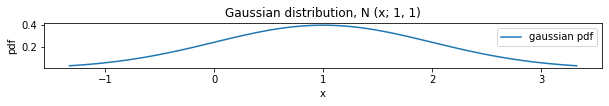

In [1]:
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=2, suppress=True)
# %matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(10,5))
mean = 1
variance = 1
x = np.linspace(norm.ppf(0.01,loc=mean,scale=variance), norm.ppf(0.99,loc=mean,scale=variance), 100)
ax.plot(x, norm.pdf(x,loc=mean,scale=variance), label='gaussian pdf')
ax.set_aspect('equal')
ax.set_xlabel("x")
ax.set_ylabel("pdf")
ax.set_title("Gaussian distribution, N (x; 1, 1)")
plt.legend()
plt.show()

B. (5 pts) What is the probability that we are actually colliding with the wall, given the prior p(x)?

Propability of collision = 0.16


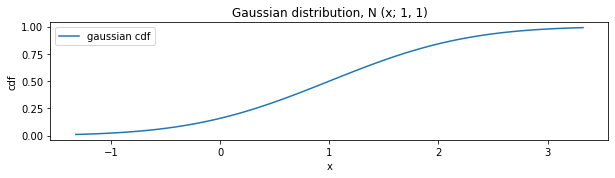

In [25]:
mean = 1
variance = 1
prop_collision = norm.cdf(0,loc=mean,scale=variance)
prop_collision = "{0:.2f}".format(prop_collision)
print(f"Propability of collision = {prop_collision}")
fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.plot(x, norm.cdf(x, loc=mean,scale=variance), label='gaussian cdf')
ax.set_aspect('equal')
ax.set_xlabel("x")
ax.set_ylabel("cdf")
ax.set_title("Gaussian distribution, N (x; 1, 1)")
plt.legend()
plt.show()

C. (5 pts) Fortunately for us (and for the robot), there is a sensor (laser, sonar, etc.) that provides an observation z regarding the distance to the nearest obstacle in front of us. The sensor is not exempt from uncertainty; thus, the likelihood function, p(z|x), is required, i.e., the pdf of z conditioned by the real position of the obstacle, x. The likelihood function is again a Gaussian distribution given by p(z|x) = N(z;x,σ2), with variance σ2 = 0.2. However, we are interested in the real distance x. Use the Bayes’ theorem to derive the posterior distribution, p(x|z), given an observation z = 0.75 and plot it. For a better comparison, plot the prior distribution, p(x), too.


Bayys' theorem: $p(x|z)=\frac{p(z|x)\cdot p(x)}{p(z)}$

$p(x)=\frac{1}{1 \cdot \sqrt{2 \pi}} e^{-\frac{(x-1)^{2}}{2 \cdot 1}}$\
$p(z^*|x)=\frac{1}{0.04 \cdot \sqrt{2 \pi}} e^{-\frac{(x-z^*)^{2}}{2 \cdot 0.04}}$ = 
$\frac{1}{0.04 \cdot \sqrt{2 \pi}} e^{-\frac{(x-0.75)^{2}}{0.08}}$\
\
Normalisation factor: $\int_{-\infty}^{\infty} p(x|z^*)dx = 1 \rightarrow p(z)=\int_{-\infty}^{\infty}p(z^*|x) \cdot p(x) = \int_{-\infty}^{\infty} N(0.75, x, 0.2) \cdot  N(x, 1, 1)dx$

Normalisation factor = 0.3548213064784985
Checking area under pdf(x|z*) =  1.0


<IPython.core.display.Javascript object>


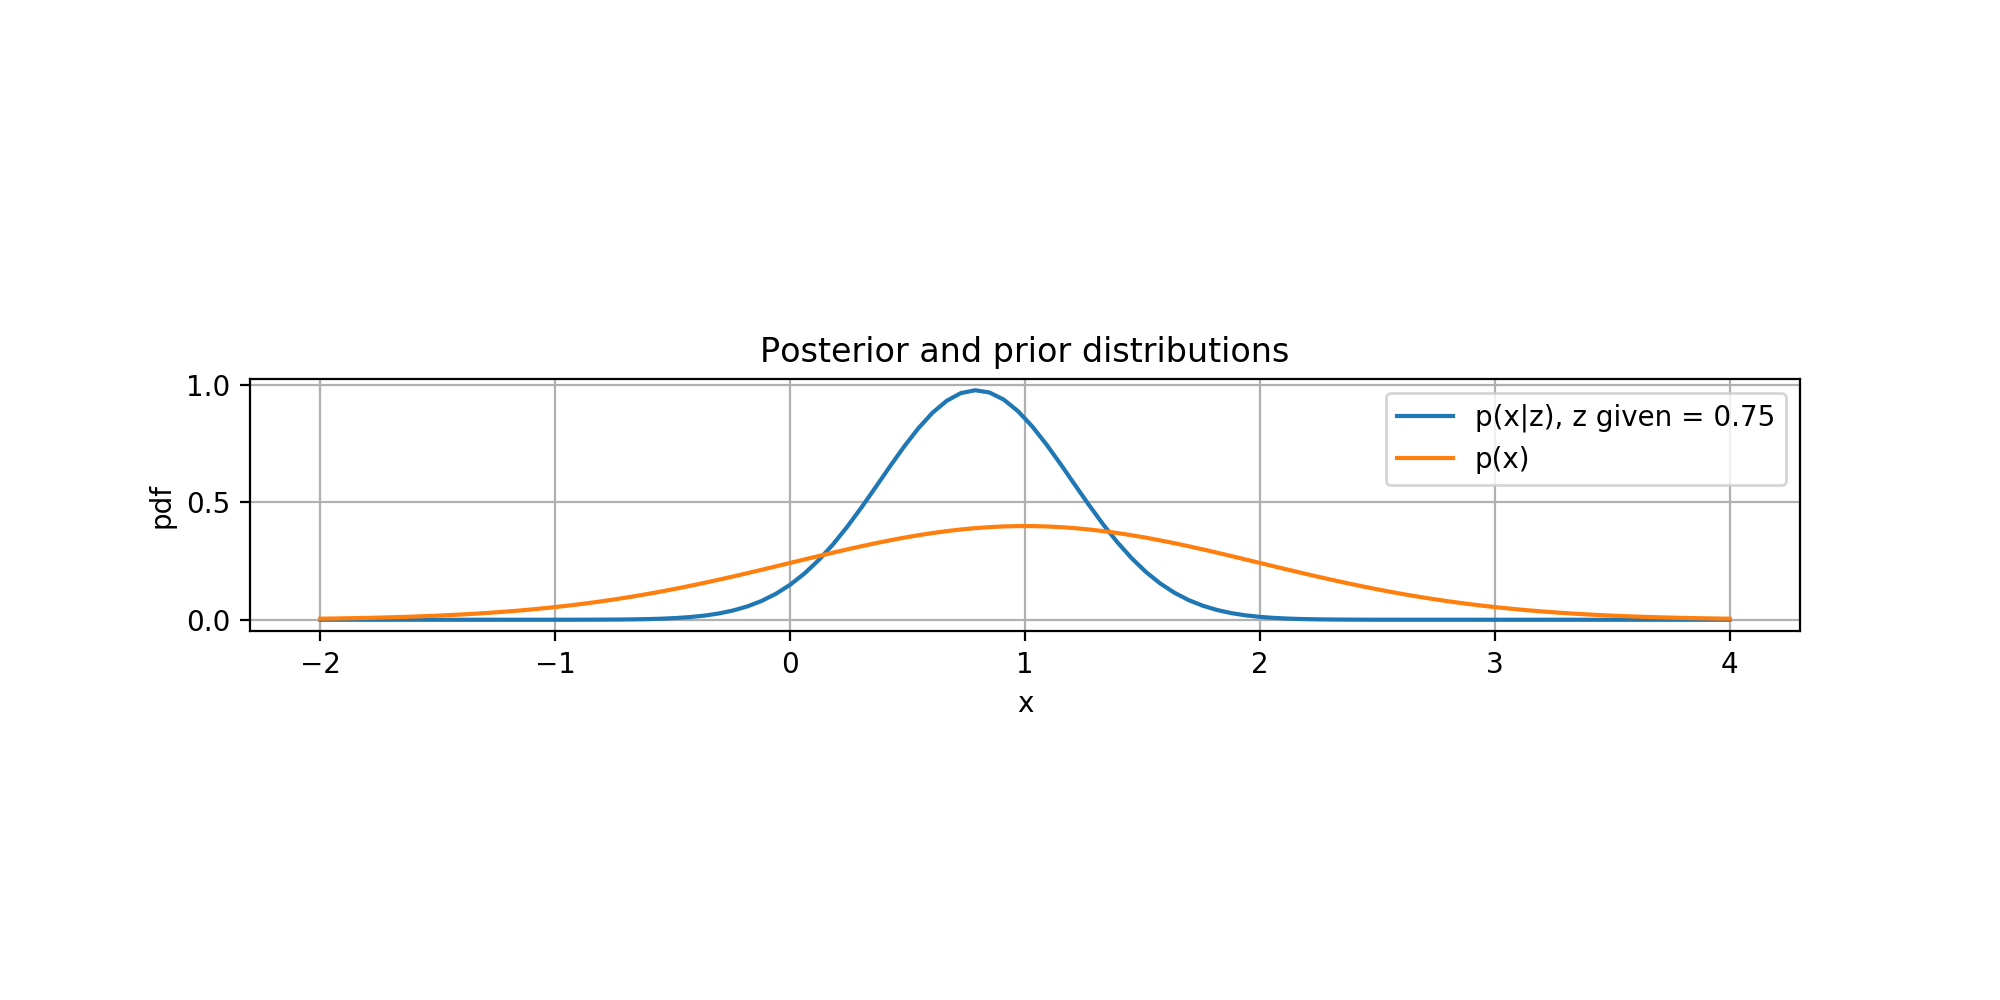

In [27]:
from scipy import integrate
%matplotlib notebook
def numerator(t):
    return norm.pdf(t, loc=0.75, scale=np.sqrt(0.2)) * norm.pdf(t, loc=1, scale=1)


"""calculation of normalisation factor"""
normalisation = integrate.quad(numerator, -np.inf, np.inf)[0] # result is first element
print("Normalisation factor =", normalisation)


def pdf_posterior(x, normalisation):
    return numerator(x) / normalisation

print("Checking area under pdf(x|z*) = ", integrate.quad(pdf_posterior, -np.inf, np.inf, args=(normalisation))[0])
x = np.linspace(-2, 4, 100)
fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.plot(x, pdf_posterior(x, normalisation), label='p(x|z), z given = 0.75')


ax.plot(x, norm.pdf(x,1,1), label='p(x)')
ax.set_aspect('equal')
ax.set_xlabel("x")
ax.set_ylabel("pdf")
ax.set_title("Posterior and prior distributions")
ax.grid(True)
plt.legend()
plt.show()



#### (5 pts) Estimate the expected value of the posterior distance to the wall E{x|z} qualitatively by inspection on the plot. The numerical solution is not necessary.

In [384]:
# Expectation value

def x_mul_pdf(x, normalisation):
    return  x * numerator(x) / normalisation

exp_value = integrate.quad(x_mul_pdf, -np.inf, np.inf, args=(normalisation))[0] # result is first element
print("Excpected value E{p(x|z*)} =", exp_value)

Excpected value E{p(x|z*)} = 0.7596153846153897


####  D.(5 pts) Plot the joint probability density function p(x, z).

<IPython.core.display.Javascript object>


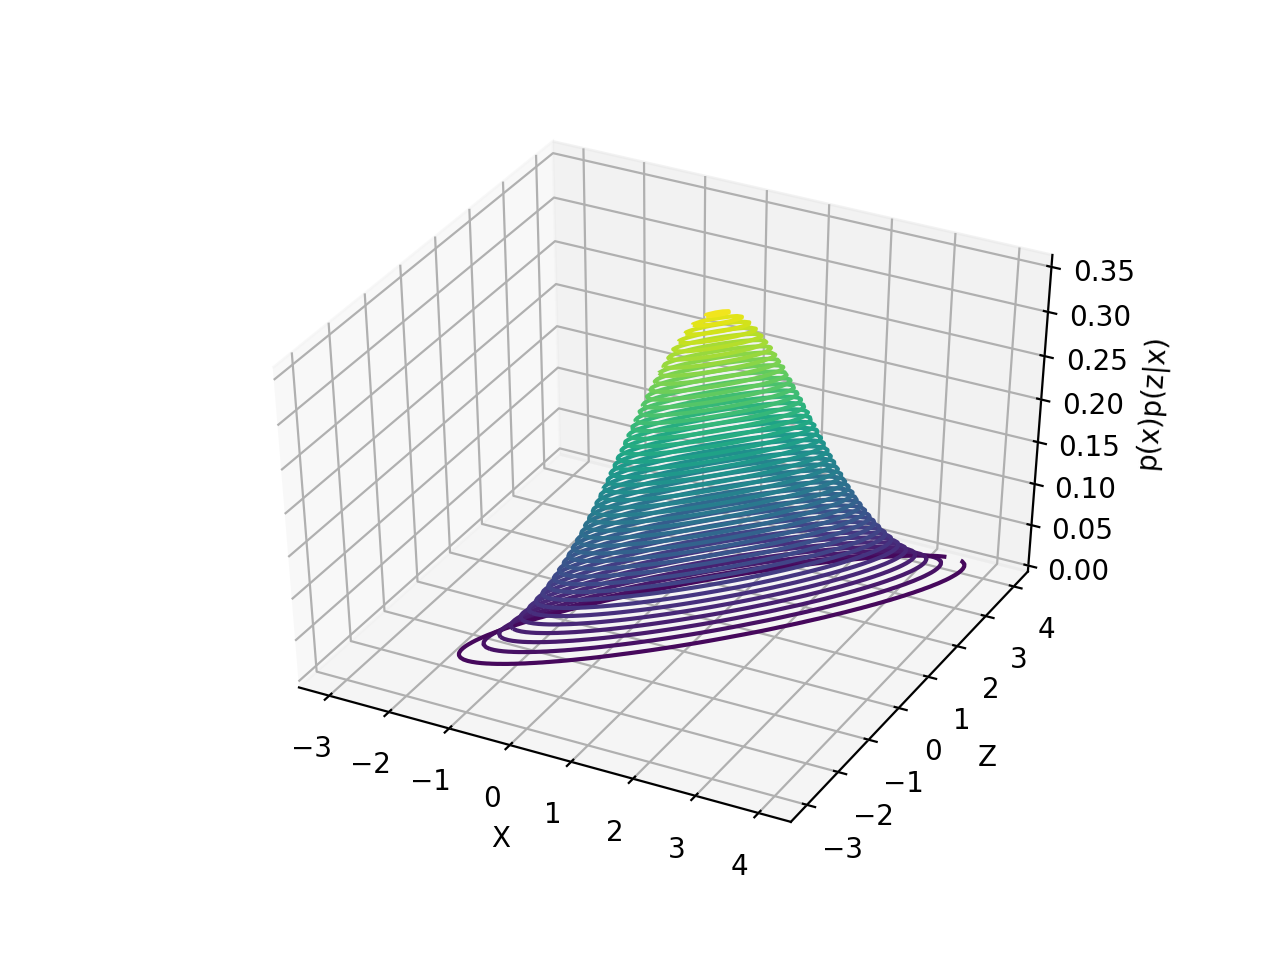

In [31]:
# p(x) - already marginalised variable
from mpl_toolkits import mplot3d
def joint_density(x, z):
    return norm.pdf(z, x, np.sqrt(0.2)) * norm.pdf(x, 1, 1)
%matplotlib notebook
x = np.linspace(-3, 4, 100)
z = np.linspace(-3, 4, 100)
X, Z = np.meshgrid(x, z)

pdf = joint_density(X.reshape(-1,1), Z.reshape(-1,1)).reshape(X.shape)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Z, pdf, 50)
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('p(x)p(z|x)');

plt.show()

### Task 2: Multivariate Gaussian (25 points)
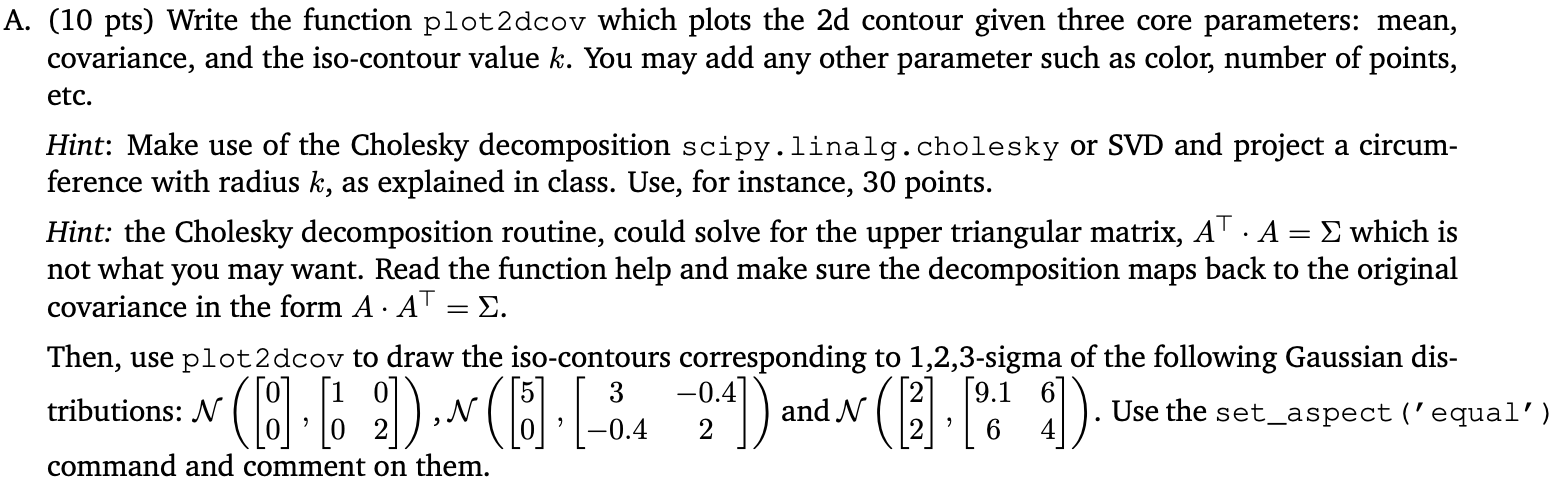

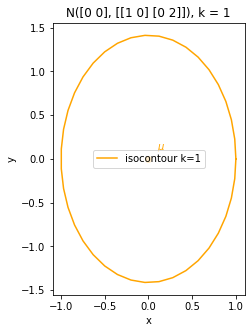

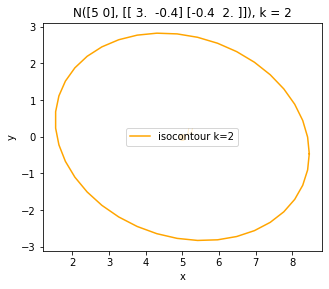

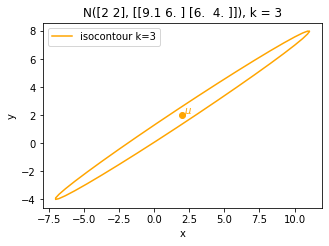

In [19]:
from scipy.linalg import cholesky
import numpy as np
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

def circle(x0y0, r, alpha):
    """
    x0y0 : Numpy
        center of sample circle
    r : float
        k from lecture
    alpha : float
        sample radian
        
    return [x,y] coresponds to [x0,y0], r, alpha
    """
    return np.array([np.cos(alpha)*r+x0y0[0], np.sin(alpha)*r+x0y0[1]])

def plot2dcov(b, Sigma_y, k, fig = None, ax = None, c="orange", isolabel=None, equal_aspect=True, text=None):
    """
    fuction to plot 2d iso-contour
    """
    L = cholesky(Sigma_y, lower=True)
    circ_samps = np.deg2rad(np.linspace(0, 360, 40))
    iso = circle([0,0], k, circ_samps)
    iso = (L @ iso.T.reshape(-1,2,1)).reshape(-1,2) + b
    
    if fig is None or ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5,5))
        
    if isolabel is not None:
        label = isolabel
    else:
        label = f"isocontour k={k}"
    ax.plot(iso[:,0], iso[:,1], label=label, c=c)
    ax.scatter(b[0],b[1], c=c)
    if equal_aspect:
        ax.set_aspect('equal')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    if text is None:
        ax.text(b[0]+0.1,b[1]+0.1,r"$\mu$",c=c)
    else:
        ax.text(b[0]+0.1,b[1]+0.1,text,c=c)
    sigma_y = str(Sigma_y).replace("\n", "")
    ax.set_title(f"N({b}, {sigma_y}), k = {k}")
    ax.legend()
    if fig is None or ax is None:
        plt.show()

    
B = [np.array([0,0]), 
     np.array([5,0]), 
     np.array([2,2])] # mean
Sigma_y = [np.array([[1,0],[0,2]]),
           np.array([[3,-0.4],[-0.4,2]]),
           np.array([[9.1,6],[6,4]])] # covariance matrix
K = [1,2,3] # sigma with constant propability

for b, sigmay, k in zip(B, Sigma_y, K):
    plot2dcov(b,sigmay,k)

#### B. (5 pts) Write the equation, in vector form, for computing the sample mean and covariance matrix of a set of points {xi}

In [119]:
def cov(m):
    """
    return covariance of Xi samples
    """
    X = np.array(m, ndmin=2, dtype=float)

    X -= X.mean(axis=1).reshape(2,1)
    N = X.shape[1]

    fact = float(N - 1)
    return (np.dot(X, X.T) / fact).squeeze()

def mean(m):
    return m.mean(axis=1)

X = np.array([[0, 2], [1, 1], [2, 0]]).T
print(f"Sample mean - {mean(X)}")
print(f"Sample covariance matrix\n{cov(X)}")


Sample mean - [1. 1.]
Sample covariance matrix
[[ 1. -1.]
 [-1.  1.]]


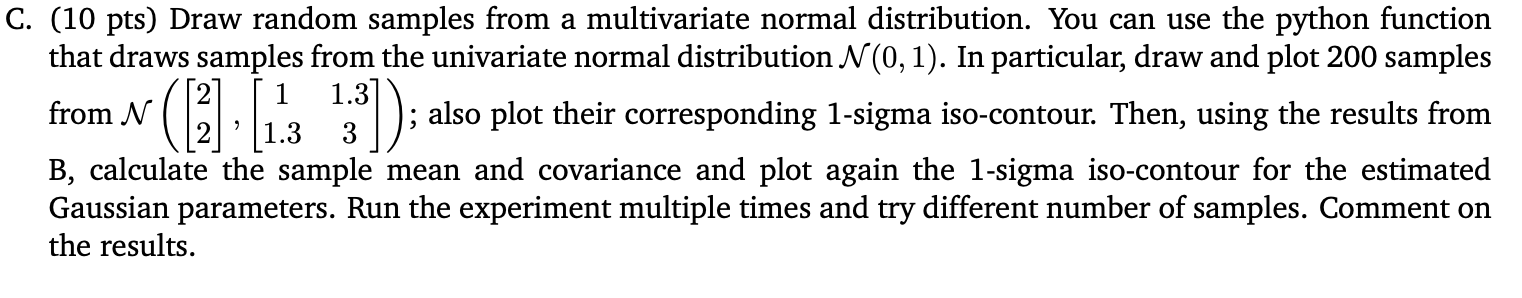

Number of samples 200
mean of multivariate normal distribution - [1.99 1.97]
cov. mat. of multivariate normal distribution - [[0.99 1.29] [1.29 2.97]]

Number of samples 10
mean of multivariate normal distribution - [1.69 1.25]
cov. mat. of multivariate normal distribution - [[1.41 1.83] [1.83 4.23]]

Number of samples 50
mean of multivariate normal distribution - [1.94 1.85]
cov. mat. of multivariate normal distribution - [[1.03 1.35] [1.35 3.1 ]]

Number of samples 100
mean of multivariate normal distribution - [1.97 1.93]
cov. mat. of multivariate normal distribution - [[1.   1.3 ] [1.3  3.01]]

Number of samples 300
mean of multivariate normal distribution - [1.99 1.98]
cov. mat. of multivariate normal distribution - [[0.99 1.29] [1.29 2.97]]

Number of samples 500
mean of multivariate normal distribution - [2.   1.99]
cov. mat. of multivariate normal distribution - [[0.99 1.28] [1.28 2.96]]

Number of samples 1000
mean of multivariate normal distribution - [2.   1.99]
cov. mat. of

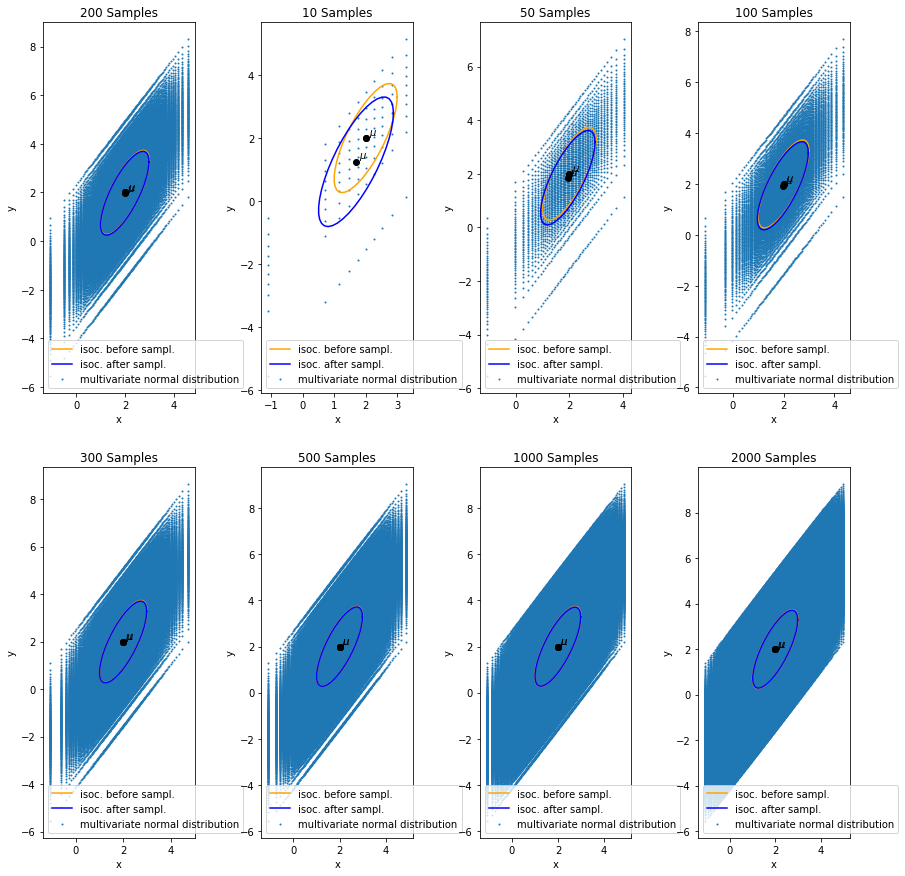

In [236]:
mean_y = np.array([2,2])
sigma_y = np.array([[1,1.3],[1.3,3]])
L = cholesky(sigma_y, lower=True)


num_samples = [200, 10, 50, 100, 300, 500, 1000, 2000]
fig, ax = plt.subplots(2, 4, figsize=(15,15))
for ax, samples in zip(list(ax.flatten()), num_samples):
    # samples from gaussian N(0,1)
    step = 0.999 / samples
    x, y = np.mgrid[0.001:0.999:step, 0.001:0.999:step]
    x, y = norm.ppf(x), norm.ppf(y)

    rv_multi = []

    for i in range(x.shape[0]):
        for j in range(y.shape[0]):
            sample = np.array([x[i][j], y[i][j]])
            rv_multi.append(L @ sample + mean_y) # affine transformation of samples
    rv_multi = np.array(rv_multi)

    ax.scatter(rv_multi[:,0], rv_multi[:,1], s=1, label="multivariate normal distribution")
    ax.scatter(mean_y[0],mean_y[1], c="black")

    plot2dcov(mean_y, sigma_y, 1, fig, ax, c="orange", isolabel="isoc. before sampl.")
    mean_multi = mean(rv_multi.T)
    cov_multi = cov(rv_multi.T)
    plot2dcov(mean_multi, cov_multi, 1, fig, ax, c="blue", isolabel="isoc. after sampl.")
    ax.set_title(f"{samples} Samples")
    print("Number of samples", samples)
    print(f"mean of multivariate normal distribution - {mean_multi}")
    cov_multi = str(cov_multi).replace("\n", "")
    print(f"cov. mat. of multivariate normal distribution - {cov_multi}\n")
plt.show()

The more points we use to calculate the covariance matrix and the mean, the less error will be

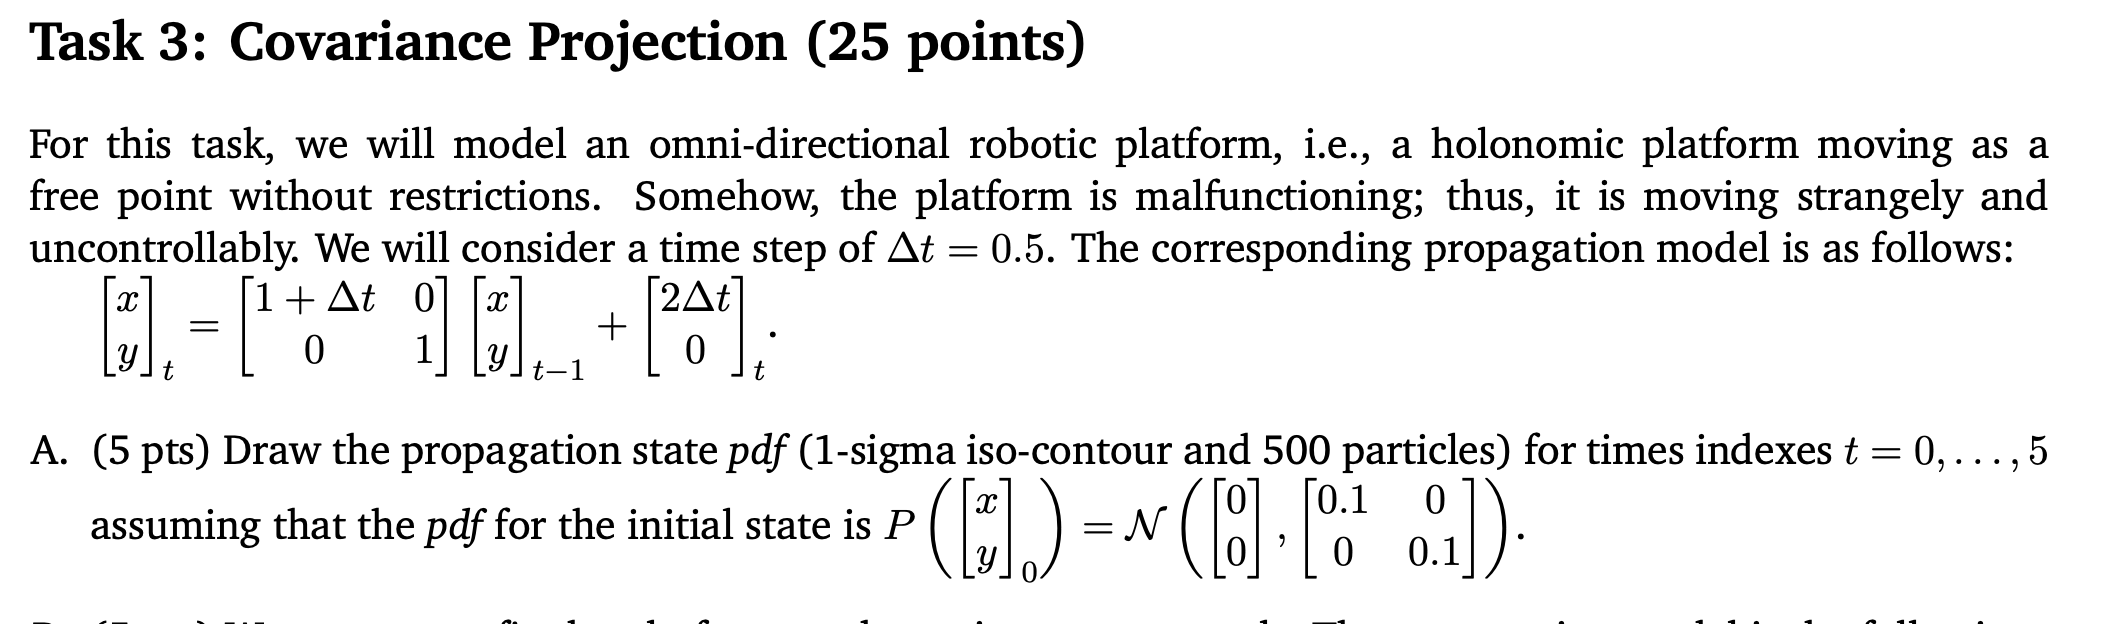

<IPython.core.display.Javascript object>


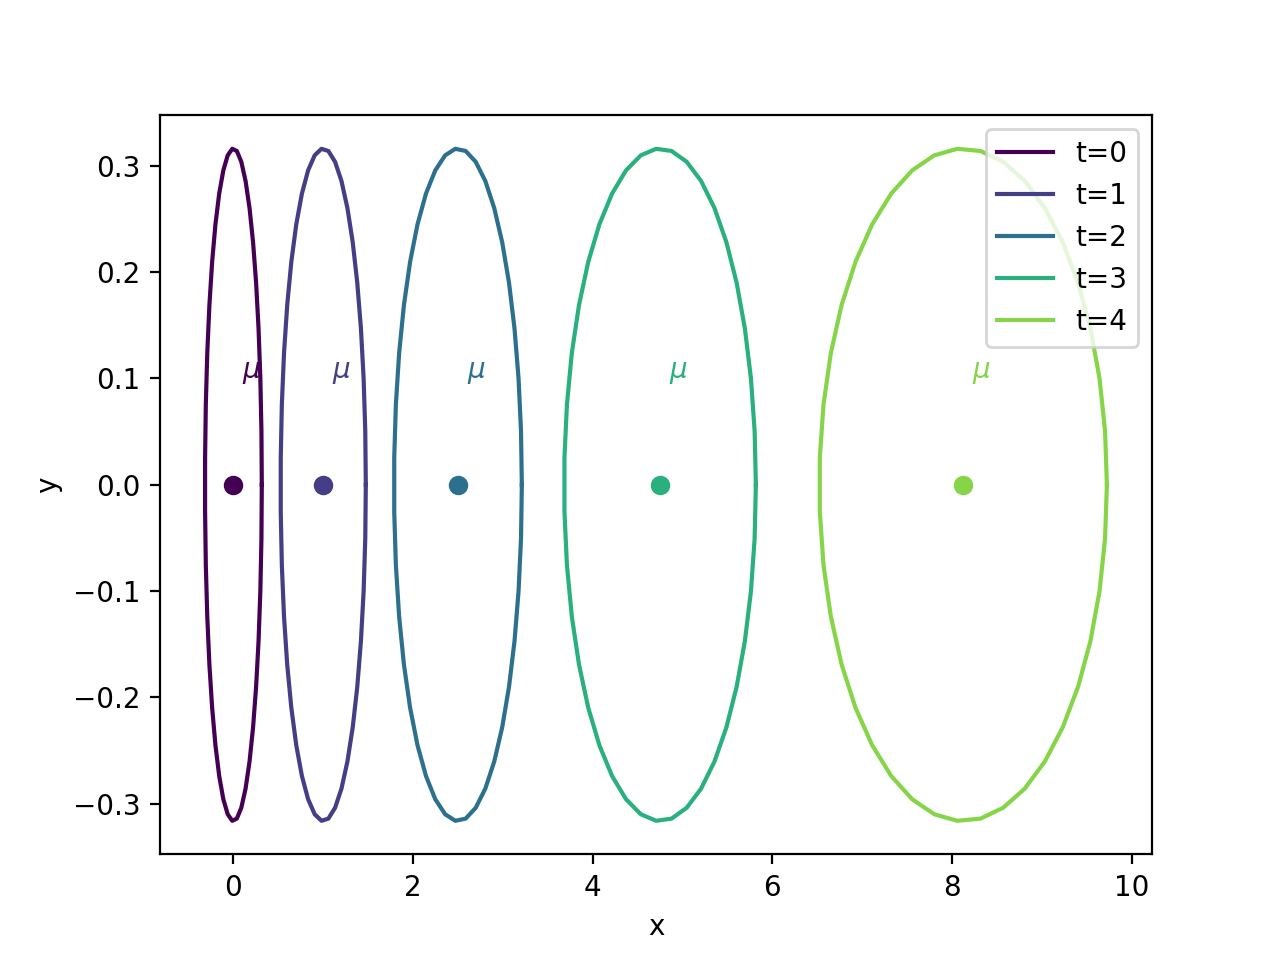

**Log:**

t = 0. Current covariance matrix
 [[0.1 0. ]
 [0.  0.1]]
t = 1. Current covariance matrix
 [[0.23 0.  ]
 [0.   0.1 ]]
t = 2. Current covariance matrix
 [[0.51 0.  ]
 [0.   0.1 ]]
t = 3. Current covariance matrix
 [[1.14 0.  ]
 [0.   0.1 ]]
t = 4. Current covariance matrix
 [[2.56 0.  ]
 [0.   0.1 ]]


In [169]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
viridis = cm.get_cmap('viridis', 12)

def A(dt):
    return np.array([[1+dt, 0],[0,1]])

def b(dt):
    return np.array([2*dt, 0])

mu_x = np.array([0,0])
Sigma_x = np.array([[0.1,0],[0,0.1]]) # initial covariance matrix
fig, ax = plt.subplots()

dt = .5
print("**Log:**\n")
for t, tt in enumerate(np.arange(0, 2.5, dt)):
    print(f"t = {t}. Current covariance matrix\n", Sigma_x)
    plot2dcov(mu_x, Sigma_x, k=1, fig=fig, ax=ax, c=viridis(t/5.0), isolabel=f"t={t}", equal_aspect=False)
    mu_y = A(dt) @ mu_x + b(dt)
    Sigma_y = A(dt) @ Sigma_x @ A(dt).T
    mu_x = mu_y
    Sigma_x = Sigma_y
    
ax.set_title("")
plt.legend(loc="upper right")
plt.show()


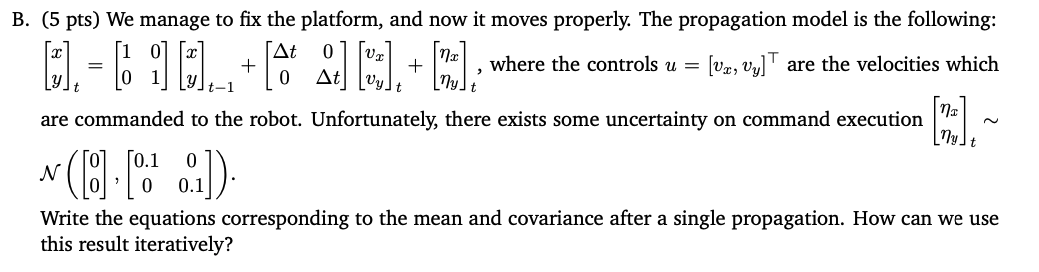

### Answer
Mean after single propagation:\
$$\mu_t=E \{Ax_{t-1}+B_tx_t+\epsilon\} = [E\{\epsilon\} = 0] =  A\mu_{t-1}+B_tx_t = \begin{bmatrix}1 & 0 \\ 0&1 \end{bmatrix}\mu_{t-1}+\begin{bmatrix}\Delta t &0\\ 0& \Delta t\end{bmatrix}u_t = \begin{bmatrix}1 & 0 \\ 0&1 \end{bmatrix}\mu_{t-1}+\begin{bmatrix}\Delta t &0\\ 0& \Delta t\end{bmatrix}\begin{bmatrix}v_x\\ v_y\end{bmatrix}$$

where, $\mu_{t-1}$ - previous state, $u_t$ - current action, scaling factor: $ A = \begin{bmatrix}1 & 0 \\ 0&1 \end{bmatrix}$, $\epsilon$ - noise in space state

Covariance after single propagation:\
$\Sigma_t=A\Sigma_{t-1}A^T + \Sigma_\eta=A\Sigma_{t-1}A^T + \begin{bmatrix}0.1 & 0 \\ 0&0.1 \end{bmatrix}$, \
where $\Sigma_\eta$ - known gaussian noise

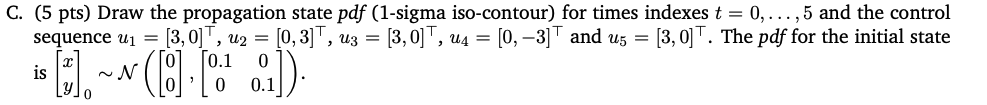

<IPython.core.display.Javascript object>


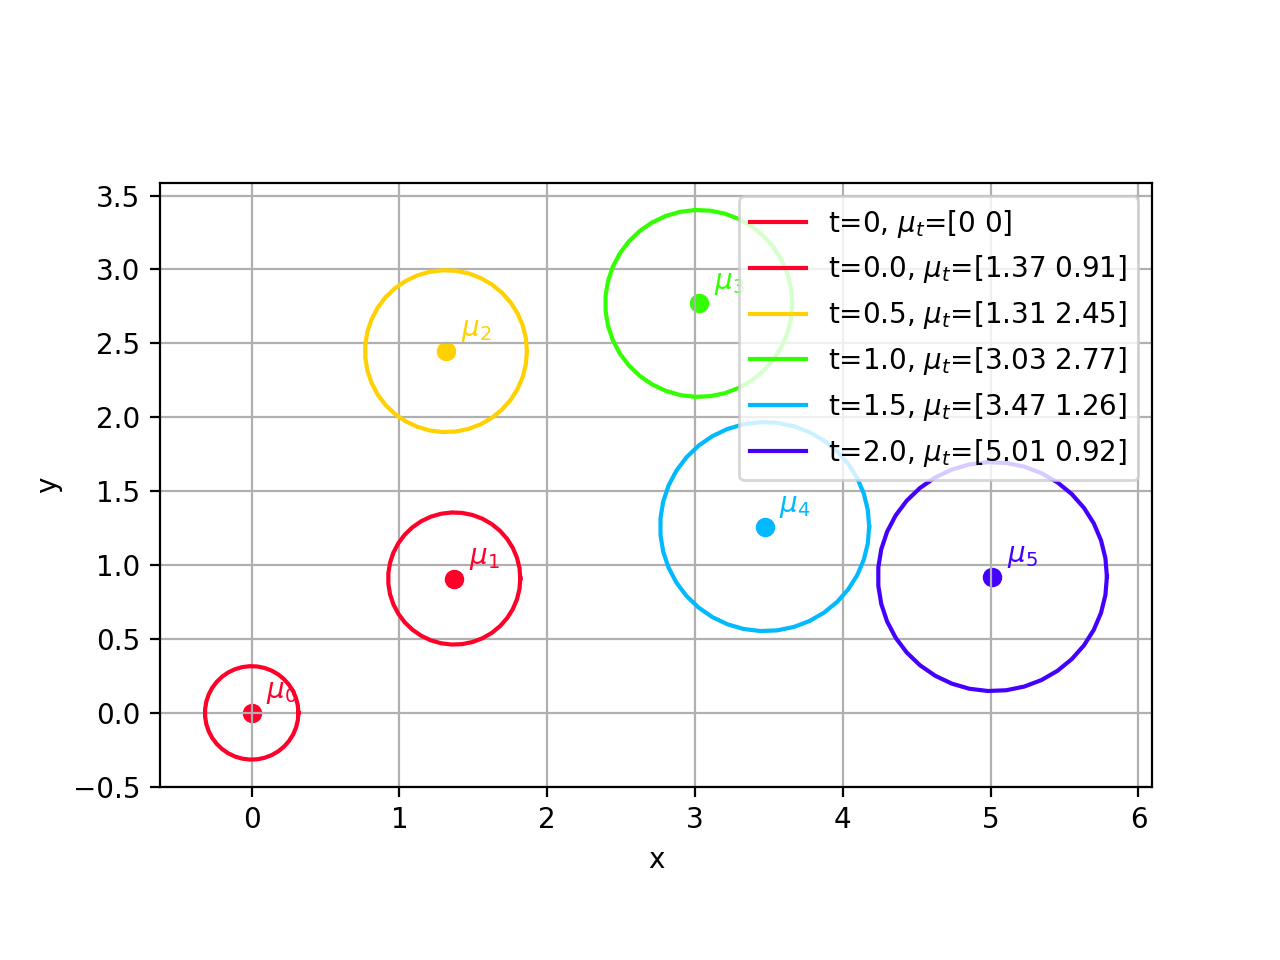

**Log:**

t = 0. u_t = [3 0]. Sigma_t =
 [[0.1 0. ]
 [0.  0.1]]
t = 0.0. u_t = [3 0]. Sigma_t =
 [[0.2 0. ]
 [0.  0.2]]
t = 0.5. u_t = [0 3]. Sigma_t =
 [[0.3 0. ]
 [0.  0.3]]
t = 1.0. u_t = [3 0]. Sigma_t =
 [[0.4 0. ]
 [0.  0.4]]
t = 1.5. u_t = [ 0 -3]. Sigma_t =
 [[0.5 0. ]
 [0.  0.5]]
t = 2.0. u_t = [3 0]. Sigma_t =
 [[0.6 0. ]
 [0.  0.6]]


In [170]:
class Noise:
    """
    class for creating noise
    """
    def __init__(self, mean, cov, shape=2):
        """
        initialisation of gaussian noise for required dimensions
        """
        self.mean = mean
        self.cov = cov
        self.shape = shape
    
    get = property()
    @get.getter
    def get(self):
        """generate noise for action space for given covariance matrix"""

        L = cholesky(self.cov, lower=True)
        samples = norm.rvs(size=self.shape)
        noise = (L @ samples + self.mean) # affine transformation, noise for action space
        return noise 

cmap = cm.get_cmap('gist_rainbow', 12)

def b(dt):
    return np.array([[dt, 0], [0,dt]])

fig, ax = plt.subplots()

A = np.eye(2,2) # scaling factor

Sigma_eta = np.array([[0.1,0],[0,0.1]]) # gaussian noise in state space!!
mu_t = np.array([0,0]) # initial sate
Sigma_t = np.array([[0.1,0],[0,0.1]]) # initial covariance matrix

noise = Noise(np.array([0,0]), Sigma_eta, shape=2) # introduce noise in space state

dt = .5
u = np.array([[3,0],[0,3],[3,0],[0,-3],[3,0]]) # action
t = np.arange(0, 2.5, dt)

print("**Log:**\n")
ti=0
print(f"t = {ti}. u_t = {ui}. Sigma_t =\n {Sigma_t}")
plot2dcov(mu_t, Sigma_t, k=1, fig=fig, ax=ax, c=cmap(ti/2.5), text=f"$\mu_{ti}$",
          isolabel=f"t={ti}, $\mu_t$={mu_t}", equal_aspect=True)
for ui, ti in zip(u, t):
    
    mu_t = A @ mu_t + b(dt) @ ui.T + noise.get
    
    Sigma_t = A @ Sigma_t @ A.T + Sigma_eta
    print(f"t = {ti}. u_t = {ui}. Sigma_t =\n {Sigma_t}")
    plot2dcov(mu_t, Sigma_t, k=1, fig=fig, ax=ax, c=cmap(ti/2.5), text=f"$\mu_{int(ti*2) + 1}$",
              isolabel=f"t={ti}, $\mu_t$={mu_t}", equal_aspect=True)
    

ax.set_title("")
ax.grid(True)
plt.show()



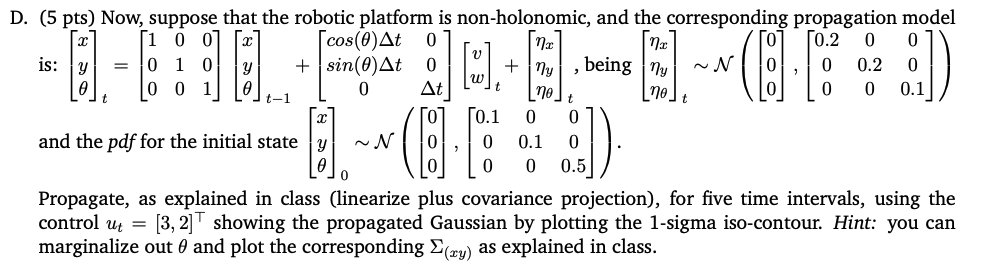

Covariance of state: $\Sigma_t = G\Sigma_{t-1}G^T$

<IPython.core.display.Javascript object>


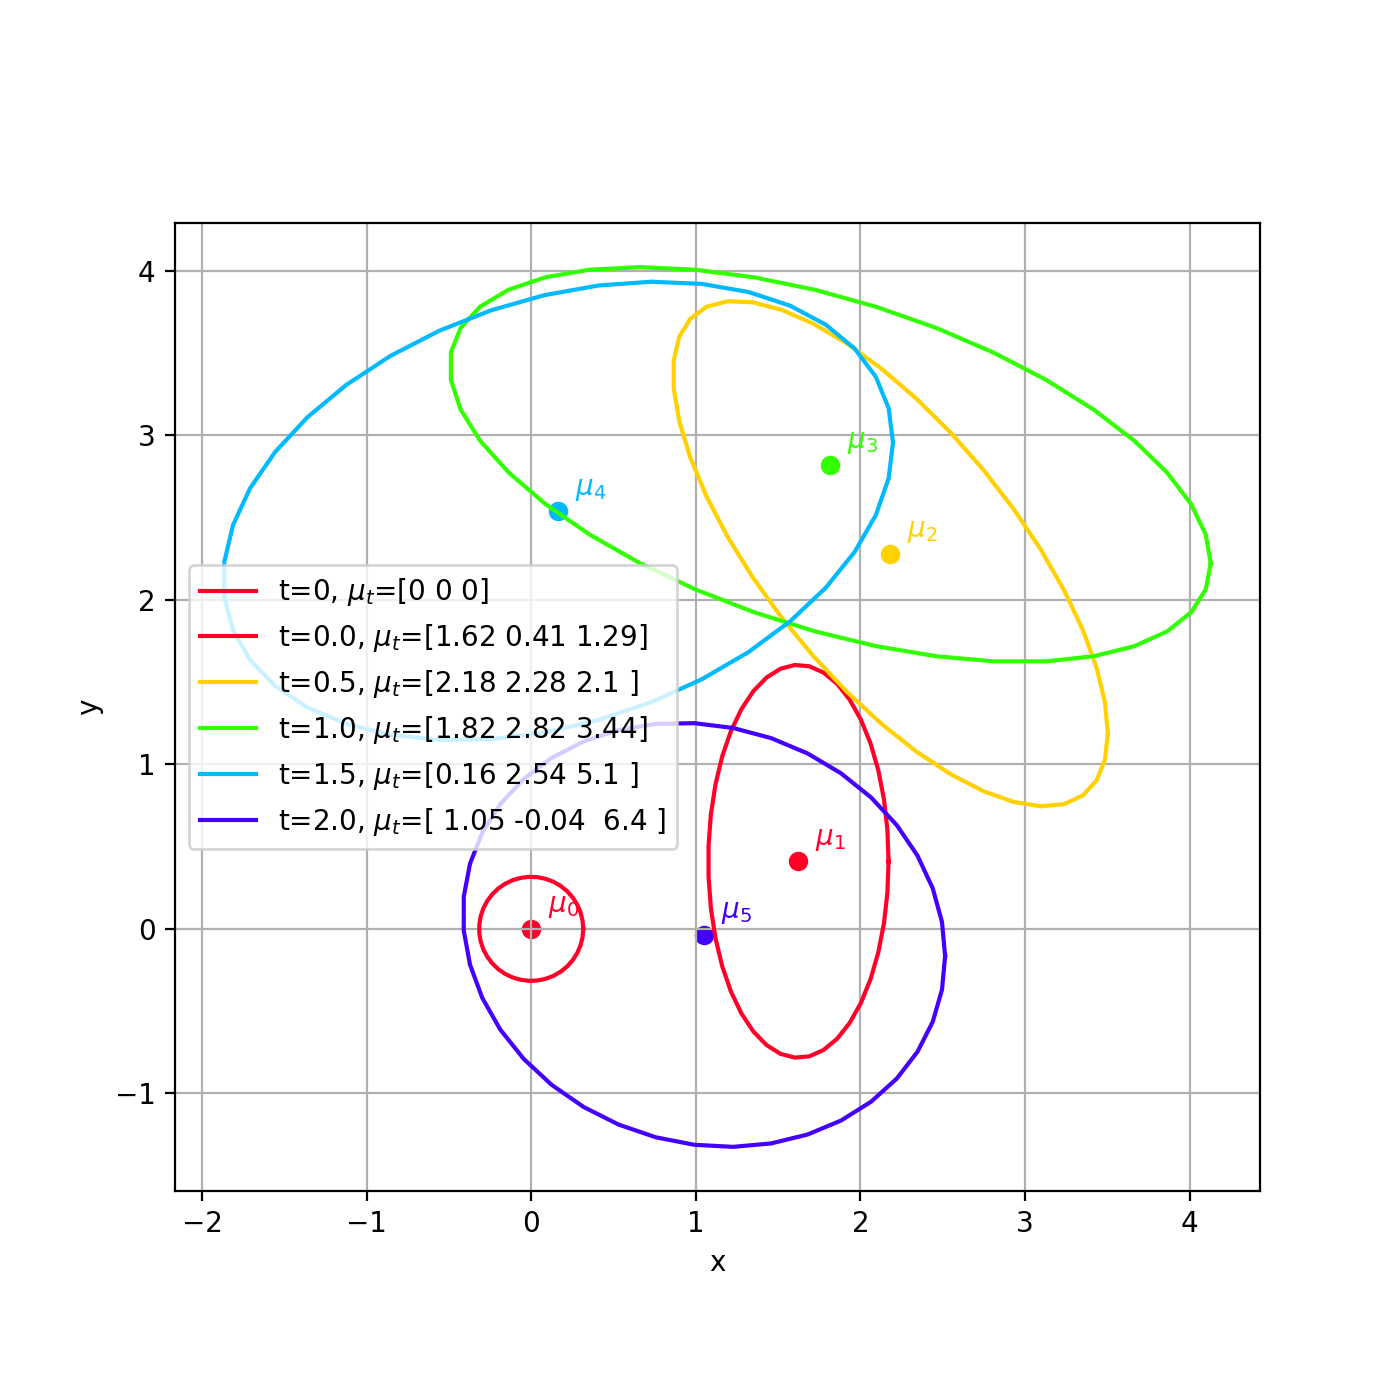

**Log:**

Sigma_t
 [[0.1 0.  0. ]
 [0.  0.1 0. ]
 [0.  0.  0.5]] 

Sigma_t
 [[0.3  0.   0.  ]
 [0.   1.43 0.75]
 [0.   0.75 0.6 ]] 

Sigma_t
 [[ 1.74 -1.44 -0.86]
 [-1.44  2.36  1.  ]
 [-0.86  1.    0.7 ]] 

Sigma_t
 [[ 5.35 -1.39 -1.77]
 [-1.39  1.44  0.47]
 [-1.77  0.47  0.8 ]] 

Sigma_t
 [[ 4.14  0.85 -1.42]
 [ 0.85  1.94 -0.68]
 [-1.42 -0.68  0.9 ]] 

Sigma_t
 [[ 2.15 -0.19 -0.17]
 [-0.19  1.66 -0.17]
 [-0.17 -0.17  1.  ]] 



In [171]:
class Noise:
    """
    class for creating noise
    """
    def __init__(self, mean, cov, shape=(2,1)):
        """
        initialisation of gaussian noise for required dimensions
        """
        self.mean = mean
        self.cov = cov
        self.shape = shape
    
    get = property()
    @get.getter
    def get(self):
        """generate noise for action space for given covariance matrix"""

        L = cholesky(self.cov, lower=True)
        samples = norm.rvs(size=self.shape)
        noise = (L @ samples + self.mean) # affine transformation, noise for action space
        return noise  


    
def G_linearisation(dt, theta, vt):
    """
    Parameters:
    dt : float
    theta : float
        theta - 1 from previous state in radians
    vt : float
        current transition velocity
    """
    return np.array([[1,0,-np.sin(theta)*dt*vt],[0,1,np.cos(theta)*dt*vt],[0,0,1]])


cmap = cm.get_cmap('gist_rainbow', 12)

def b(dt, theta):
    """
    Parameters:
    dt : float
    theta : float
        theta - 1 from previous state in radians
    """
    return np.array([[dt*np.cos(theta), 0],[dt*np.sin(theta), 0], [0,dt]])

fig, ax = plt.subplots(figsize=(7,7))

A = np.eye(3,3) # scaling factor

Sigma_eta = np.array([[0.2,0,0],[0,0.2,0],[0,0,0.1]]) # gaussian noise in state space
mu_t = np.array([0,0,0]) # initial sate
Sigma_t = np.array([[0.1,0,0],[0,0.1,0],[0,0,0.5]]) # initial covariance matrix

noise = Noise(np.array([0,0,0]), Sigma_eta, shape=3) # introduce noise in space state

dt = .5
ut = np.array([3,2]) # current action
vt = ut[0] # linear velocity
omega = ut[1] # angular velocity in radians
t = np.arange(0, 2.5, dt)


print("**Log:**\n")
ti=0
plot2dcov(mu_t[0:2], Sigma_t[0:2, 0:2], k=1, fig=fig, ax=ax, text=f"$\mu_{ti}$",
          c=cmap(ti/6.0), isolabel=f"t={ti}, $\mu_t$={mu_t}", equal_aspect=True)
print("Sigma_t\n", Sigma_t, "\n")
    
for ti in t:
    
    theta_prev_t = mu_t[2]
    mu_t = A @ mu_t + b(dt, theta_prev_t) @ ut + noise.get # affine transformation
    G = G_linearisation(dt, theta_prev_t, vt) # Linearisation of current state
    Sigma_t = G @ Sigma_t @ G.T + Sigma_eta # adding noise to state space!!!
    plot2dcov(mu_t[0:2], Sigma_t[0:2, 0:2], k=1, fig=fig, ax=ax, text=f"$\mu_{int(ti*2) + 1}$",
              c=cmap(ti/2.5), isolabel=f"t={ti}, $\mu_t$={mu_t}", equal_aspect=True)
    print("Sigma_t\n", Sigma_t, "\n")
    
ax.set_title("")
ax.grid(True)
plt.show()

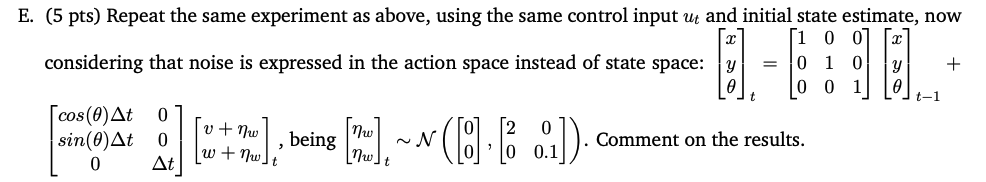

Covariance of state: $\Sigma_t =G \Sigma_T G^T +  B\Sigma_{\eta_t-1} B^T  $

<IPython.core.display.Javascript object>


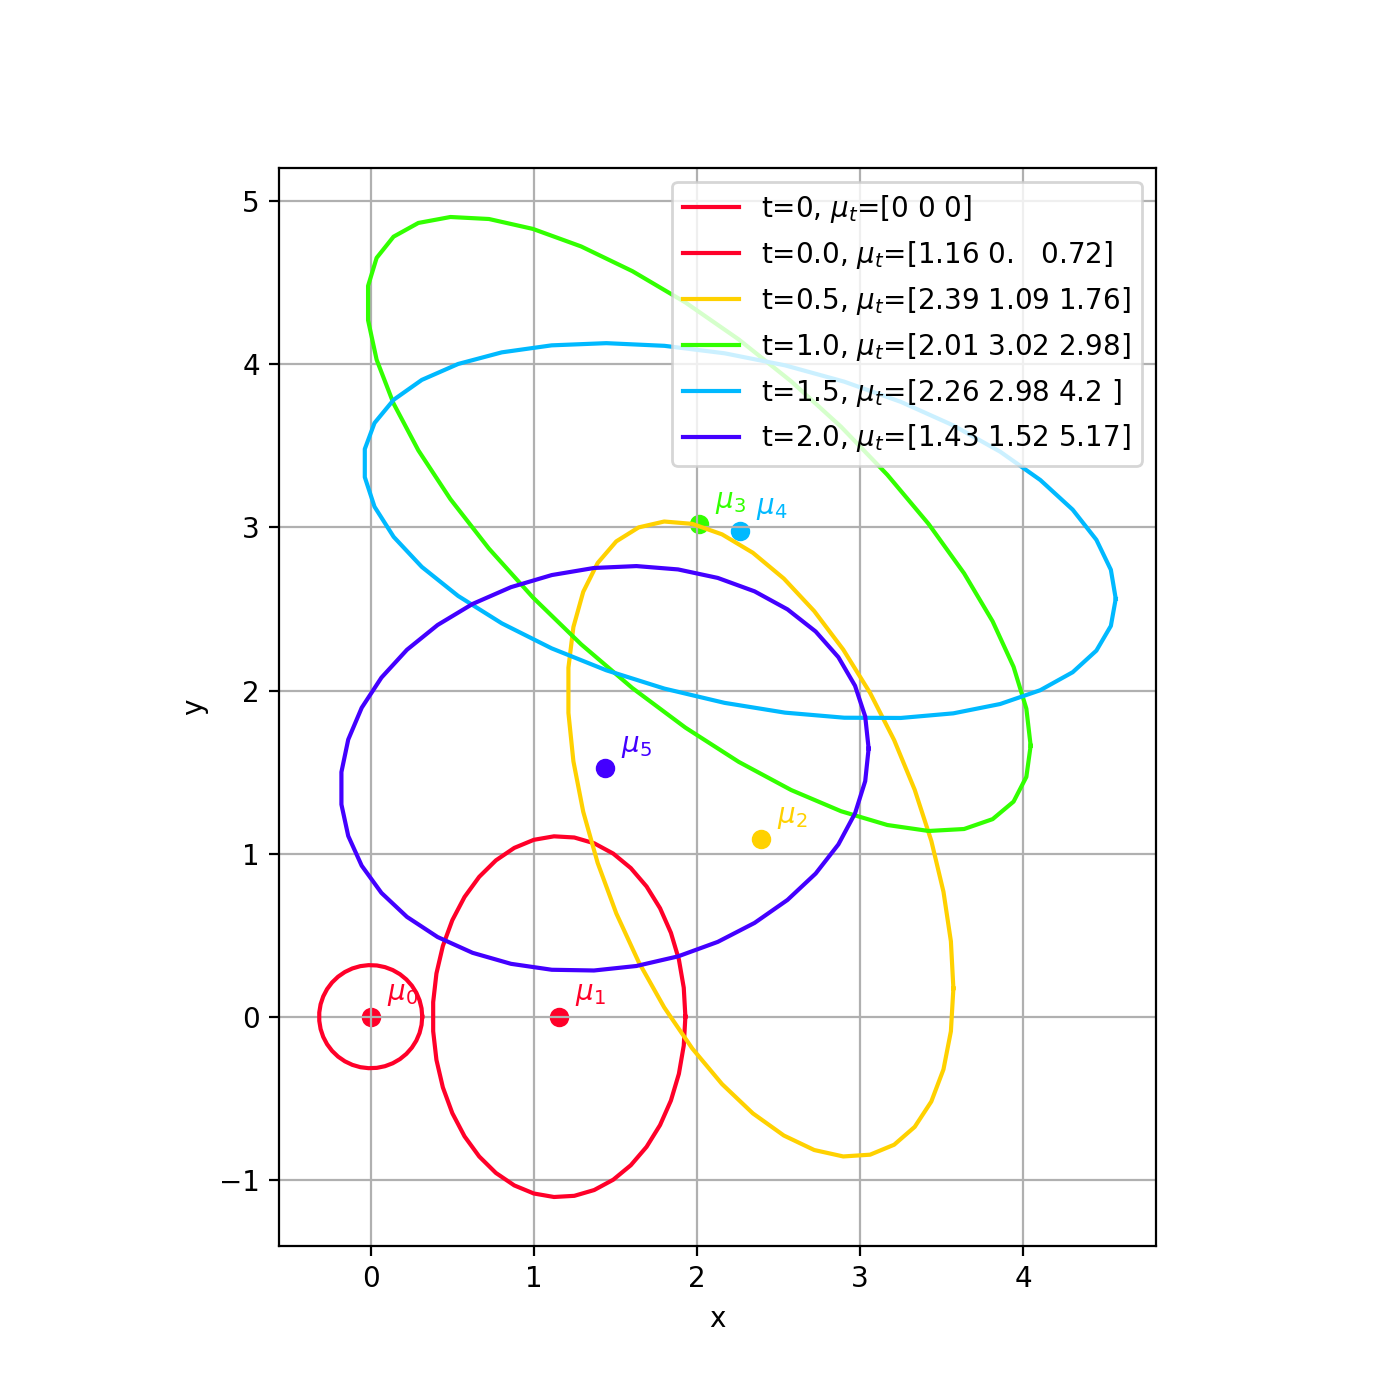

**Log:**

Sigma_t
 [[0.1 0.  0. ]
 [0.  0.1 0. ]
 [0.  0.  0.5]] 

Sigma_t
 [[0.6  0.   0.  ]
 [0.   1.23 0.75]
 [0.   0.75 0.53]] 

Sigma_t
 [[ 1.4  -1.08 -0.52]
 [-1.08  3.8   1.34]
 [-0.52  1.34  0.55]] 

Sigma_t
 [[ 4.14 -2.77 -1.33]
 [-2.77  3.55  1.18]
 [-1.33  1.18  0.58]] 

Sigma_t
 [[ 5.32 -0.96 -1.47]
 [-0.96  1.32  0.33]
 [-1.47  0.33  0.6 ]] 

Sigma_t
 [[ 2.62  0.2  -0.69]
 [ 0.2   1.54 -0.11]
 [-0.69 -0.11  0.63]] 



In [165]:
class Noise:
    """
    class for creating noise
    """
    def __init__(self, mean, cov, shape=(2,1)):
        """
        initialisation of gaussian noise for required dimensions
        """
        self.mean = mean
        self.cov = cov
        self.shape = shape
    
    get = property()
    @get.getter
    def get(self):
        """generate noise for action space for given covariance matrix"""

        L = cholesky(self.cov, lower=True)
        samples = norm.rvs(size=self.shape)
        noise = (L @ samples + self.mean) # affine transformation, noise for action space
        return noise  



def G_linearisation(dt, theta, vt):
    """
    Parameters:
    dt : float
    theta : float
        theta - 1 from previous state in radians
    vt : float
        current transition velocity
    """
    return np.array([[1,0,-np.sin(theta)*dt*vt],[0,1,np.cos(theta)*dt*vt],[0,0,1]])


def b(dt, theta):
    """
    Parameters:
    dt : float
    theta : float
        theta - 1 from previous state in radians
    """
    return np.array([[dt*np.cos(theta), 0],[dt*np.sin(theta), 0], [0, dt]])


fig, ax = plt.subplots(figsize=(7,7))
cmap = cm.get_cmap('gist_rainbow', 12)


A = np.eye(3,3) # scaling factor
mu_t = np.array([0,0,0]) # initial sate
Sigma_t = np.array([[0.1,0,0],[0,0.1,0],[0,0,0.5]]) # initial covariance matrix
Sigma_eta = np.array([[2,0],[0,0.1]])
noise = Noise(np.array([0,0]), Sigma_eta, shape=2) # introduce noise in action space

dt = .5
ut = np.array([3,2]) # current action
vt = ut[0] # linear velocity
omega = ut[1] # angular velocity in radians
t = np.arange(0, 2.5, dt)

print("**Log:**\n")
ti = 0
plot2dcov(mu_t[0:2], Sigma_t[0:2, 0:2], k=1, fig=fig, ax=ax, text=f"$\mu_{ti}$",
              c=cmap(ti/6.0), isolabel=f"t={ti}, $\mu_t$={mu_t}", equal_aspect=True)
print("Sigma_t\n", Sigma_t, "\n")
for ti in t:
    
    theta_prev_t = mu_t[2]
    B = b(dt, theta_prev_t)
    mu_t = A @ mu_t + B @ (ut + noise.get) # affine transformation  
    G = G_linearisation(dt, theta_prev_t, vt) # Linearisation of current state
    Sigma_t = G @ Sigma_t @ G.T + B @ Sigma_eta @ B.T# covariance for current state + transorming are noise
    plot2dcov(mu_t[0:2], Sigma_t[0:2, 0:2], k=1, fig=fig, ax=ax, text=f"$\mu_{int(ti*2)+1}$",
              c=cmap(ti/2.5), isolabel=f"t={ti}, $\mu_t$={mu_t}", equal_aspect=True)
    print("Sigma_t\n", Sigma_t, "\n")
    
ax.set_title("")
ax.grid(True)
plt.show()

Explanation: Including noise in action space are affect on position more than noise in state space (because noise are adding directly on action)
